##Importe de las librerías y carga del modelo

Nuevamente, importamos en primer lugar todas las librerías necesarias para cargar correctamente el modelo

In [ ]:
import keras
import sklearn
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPool2D, AveragePooling2D, Input, BatchNormalization, MaxPooling2D, Activation, Flatten, Dense, Dropout
from keras.models import Sequential
from keras.utils import np_utils
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from keras.preprocessing import image
import scipy
import os
from PIL import Image
from tqdm import tqdm
import cv2
from numpy.lib.type_check import imag

Abrimos ahora el archivo que contiene la ruta del modelo

In [ ]:
json_file = open('drive/MyDrive/Proyecto4_CienciaDatos/Model_EmotionsClassifier/model/model.json','r')
model_json = json_file.read()
json_file.close()

Y cargamos tanto la arquitectura, pesos, los criterios y el optimizador

In [ ]:
model = keras.models.model_from_json(model_json)
model.load_weights("drive/MyDrive/Proyecto4_CienciaDatos/Model_EmotionsClassifier/model/model.h5")

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

## Carga de los datos predecidos y análisis de estos

Leemos ahora los datos de testeo que guardamos en el cuaderno anterior, sustentados en el hecho de no escoger aleatoriamente nuevos datos que podrían ser los mismos con los que el modelo fue entrenado inicialmente.

In [ ]:
x_test = np.loadtxt('drive/MyDrive/Proyecto4_CienciaDatos/Model_EmotionsClassifier/data/X_test.txt')
y_test = np.loadtxt('drive/MyDrive/Proyecto4_CienciaDatos/Model_EmotionsClassifier/data/Y_test.txt')
y_pred = np.loadtxt('drive/MyDrive/Proyecto4_CienciaDatos/Model_EmotionsClassifier/data/Y_pred.txt')

Definimos la función que nos creará la matrix de confusión para analizar las predicciones de nuestro modelo

In [ ]:
def CM(Y_true, Y_pred, classes):
  fig = plt.figure(figsize=(10, 10))
  cm = sklearn.metrics.confusion_matrix(Y_true, Y_pred)
  lclasses = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  cmap=plt.cm.Blues
  ax = fig.add_subplot(1,1,1)
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax, pad=0.01, shrink=0.86)
  ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),xticklabels=lclasses, yticklabels=lclasses)
  ax.set_xlabel("Predicted",size=20)
  ax.set_ylabel("True",size=20)
  ax.set_ylim(classes-0.5, -0.5)

  plt.setp(ax.get_xticklabels(), size=12)
  plt.setp(ax.get_yticklabels(), size=12)

  fmt = '.2f'
  thresh = cm.max()/2.
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center",size=15 , color="white" if cm[i, j] > thresh else "black")

  plt.savefig('/content/drive/MyDrive/Proyecto4_CienciaDatos/images/confussionMatrix.png', dpi=200)

Graficamos nuestra matrix

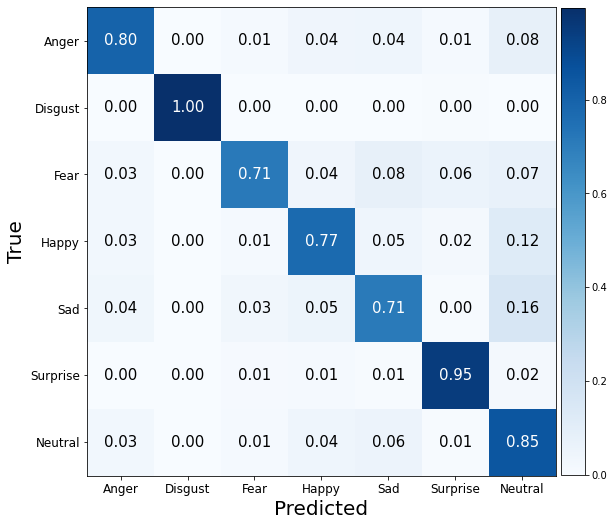

In [ ]:
CM(y_test, y_pred, 7)

Y calculamos nuestro *f1_score* relativo a los datos de testeo

In [ ]:
print('f1_score: {:.4f}'.format(sklearn.metrics.f1_score(y_test, y_pred, average='weighted')))

f1_score: 0.8269


Con ayuda de la librería cv2, creamos una función que detecte los rostros en las imágenes, las recorte centrando las caras y finalmente las transforme para que tengan el tamaño adecuado del modelo **(48,48)**

In [ ]:
def detect_and_resize_faces(img):
    img = img.astype("uint8")
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(img, 1.01, 5)
    if len(faces) == 0:
        haar_img = img
    else:
        x, y, w, h = faces[0]
        haar_img = img[y:y+h, x:x+w]
        
    return cv2.resize(((haar_img).astype("float32")), (48,48))

Y creamos rápidamente un diccionario para traducir las clases a las emociones correspondientes

In [ ]:
emotions = {0: 'Anger', 1: 'Disgust',
            2: 'Fear', 3: 'Happy',
            4: 'Sad', 5: 'Surprise',
            6: 'Neutral'}

In [ ]:
anger = detect_and_resize_faces(np.array(Image.open(r"drive/MyDrive/Proyecto4_CienciaDatos/Model_EmotionsClassifier/images_ours/angerP.jpg").convert('L')))
disgust = detect_and_resize_faces(np.array(Image.open(r"drive/MyDrive/Proyecto4_CienciaDatos/Model_EmotionsClassifier/images_ours/disgustH.jpg").convert('L')))
fear = detect_and_resize_faces(np.array(Image.open(r"drive/MyDrive/Proyecto4_CienciaDatos/Model_EmotionsClassifier/images_ours/fearJ.jpg").convert('L')))
happy = detect_and_resize_faces(np.array(Image.open(r"drive/MyDrive/Proyecto4_CienciaDatos/Model_EmotionsClassifier/images_ours/happyS.jpg").convert('L')))
sad = detect_and_resize_faces(np.array(Image.open(r"drive/MyDrive/Proyecto4_CienciaDatos/Model_EmotionsClassifier/images_ours/sadH.jpg").convert('L')))
surprise = detect_and_resize_faces(np.array(Image.open(r"drive/MyDrive/Proyecto4_CienciaDatos/Model_EmotionsClassifier/images_ours/surpriseB.jpg").convert('L')))
neutral = detect_and_resize_faces(np.array(Image.open(r"drive/MyDrive/Proyecto4_CienciaDatos/Model_EmotionsClassifier/images_ours/neutralJ.jpg").convert('L')))

In [ ]:
emotion_anger = emotions[np.argmax(model.predict(np.array(anger).reshape(-1, 48, 48, 1)/255))]
emotion_disgust = emotions[np.argmax(model.predict(np.array(disgust).reshape(-1, 48, 48, 1)/255))]
emotion_fear = emotions[np.argmax(model.predict(np.array(fear).reshape(-1, 48, 48, 1)/255))]
emotion_happy = emotions[np.argmax(model.predict(np.array(happy).reshape(-1, 48, 48, 1)/255))]
emotion_sad = emotions[np.argmax(model.predict(np.array(sad).reshape(-1, 48, 48, 1)/255))]
emotion_surprise = emotions[np.argmax(model.predict(np.array(surprise).reshape(-1, 48, 48, 1)/255))]
emotion_neutral = emotions[np.argmax(model.predict(np.array(neutral).reshape(-1, 48, 48, 1)/255))]

In [ ]:
prediction_anger = model.predict(np.array(anger).reshape(-1, 48, 48, 1)/255)[0][0]
prediction_disgust = model.predict(np.array(disgust).reshape(-1, 48, 48, 1)/255)[0][1]
prediction_fear = model.predict(np.array(fear).reshape(-1, 48, 48, 1)/255)[0][2]
prediction_happy = model.predict(np.array(happy).reshape(-1, 48, 48, 1)/255)[0][3]
prediction_sad = model.predict(np.array(sad).reshape(-1, 48, 48, 1)/255)[0][4]
prediction_surprise = model.predict(np.array(surprise).reshape(-1, 48, 48, 1)/255)[0][5]
prediction_neutral = model.predict(np.array(neutral).reshape(-1, 48, 48, 1)/255)[0][6]

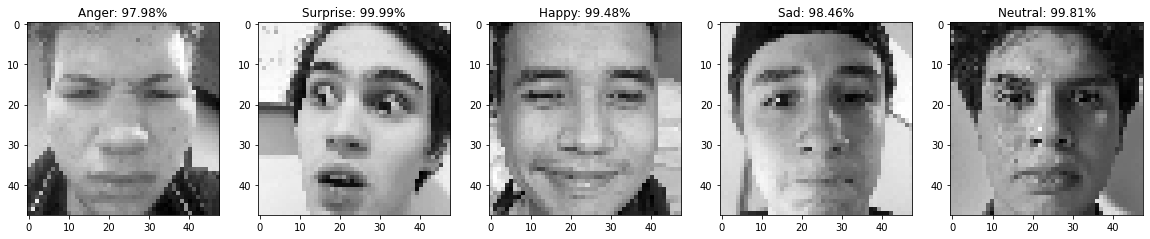

In [ ]:
plt.figure(figsize=(20,5))

plt.subplot(1,5,1)
plt.imshow(img, cmap='gray')
plt.title('Anger: {:.2f}%'.format(prediction_anger*100))

plt.subplot(1,5,2)
plt.imshow(surprise, cmap='gray')
plt.title('Surprise: {:.2f}%'.format(prediction_surprise*100))

plt.subplot(1,5,3)
plt.imshow(happy, cmap='gray')
plt.title('Happy: {:.2f}%'.format(prediction_happy*100))

plt.subplot(1,5,4)
plt.imshow(sad, cmap='gray')
plt.title('Sad: {:.2f}%'.format(prediction_sad*100))

plt.subplot(1,5,5)
plt.imshow(neutral, cmap='gray')
plt.title('Neutral: {:.2f}%'.format(prediction_neutral*100))

plt.savefig('/content/drive/MyDrive/Proyecto4_CienciaDatos/images/results.png', dpi=200)

Motivados con estos resultados, podemos pasar a desarrollar una interfaz en la que sea posible correr el modelo de manera más amigable